In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from ipywidgets import interactive
import ipywidgets

In [2]:
#get file
#print("import your data.xlsx, .xls, or .csv to your working directory\nensure columns are correctly formatted:\nsheet 1:\tt1\t[A1]\t[B1]\t...\nsheet 2:\tt2\t[A2]\t[B2]\n...")
filename = input('full name of excel file: ')
xl = pd.ExcelFile(filename)
R = []
#import excel sheets of reaction 1 and 2
for i in range(len(xl.sheet_names)):
    R.append(pd.read_excel(filename, i))
    #print("\ncolumns read from experiment 1: \n{}".format(str(R.columns)[7:-18]))

full name of excel file: sampledata/VTNA329.xlsx


In [28]:
concs = [0.0510,0.0578,0.0688,0.0750,0.104,0.125,0.127,0.142]

In [151]:
#user input on Normalization Type
conc = []
#normalization_method = input('MV, TC or no normalization? ')
for i in range(len(xl.sheet_names)):
    conc.append(float(input("value (unitless) for relative concentration of reagent/catalyst in {} acting on column {}: ".format(xl.sheet_names[i], j))))

value (unitless) for relative concentration of reagent/catalyst in 1mM acting on column 2: 2
value (unitless) for relative concentration of reagent/catalyst in 2mM acting on column 2: 1


In [9]:
normalization_method = input("normalization method (Total count, Max Value or none): ")

normalization method (Total count, Max Value or none): TC


In [61]:
#produce a column summing all counts at each 
# timestep for total ion count normalization 
def get_TC(df):
    totaled = np.zeros(len(df))
    for j,col in enumerate(df.columns):
        if j > 0:
            totaled += df[col]
    return totaled

def testtc(df):
    return df.values[:, 1:].sum(axis=1)

In [62]:
testtc(R[1]), get_TC(R[1])

(array([1.48390212e+09, 1.45677926e+09, 1.43327061e+09, ...,
        2.18500000e+03, 0.00000000e+00, 0.00000000e+00]), 0       1.483902e+09
 1       1.456779e+09
 2       1.433271e+09
 3       1.408587e+09
 4       1.408728e+09
 5       1.390438e+09
 6       1.427581e+09
 7       1.410475e+09
 8       1.380107e+09
 9       1.396579e+09
 10      1.409223e+09
 11      1.420670e+09
 12      1.387051e+09
 13      1.408200e+09
 14      1.414728e+09
 15      1.421409e+09
 16      1.436921e+09
 17      1.415392e+09
 18      1.407282e+09
 19      1.413721e+09
 20      1.402761e+09
 21      1.439611e+09
 22      1.409119e+09
 23      1.400934e+09
 24      1.402680e+09
 25      1.425287e+09
 26      1.432466e+09
 27      1.409471e+09
 28      1.406858e+09
 29      1.429986e+09
             ...     
 2911    1.833266e+08
 2912    7.848593e+07
 2913    7.682826e+07
 2914    6.107564e+07
 2915    3.674051e+07
 2916    2.215154e+07
 2917    1.865386e+07
 2918    2.804460e+07
 2919    9.046860e+06
 2

In [65]:
#if statements for possible normalization routes
Total = []
if normalization_method == "TC":
    for i in range(len(xl.sheet_names)):
        Total.append(get_TC(R[i]))
elif normalization_method == "MV":
    for i in range(len(xl.sheet_names)):
        Total.append(R[i].iloc[:, 1:].max().max())
#if neither TC nor MV is selected, the operations of Total1 and Total2
#will not change any values
else:
    Total = 1

In [68]:
#function that normalize all columns by the sum on that time step (excludes the time coumn in a sheet)
def normalize_columns(sheetname, total):
    sheetnorm = sheetname.copy()
    for i,col in enumerate(sheetname.columns):
        if i > 0:
            sheetnorm.loc[:,col]/= total
    return sheetnorm

In [75]:
#function which creates an interactive plot for user to zero their data and smooth datapoints
#inner function only passes variables assigned to widgets
#outer function allows interactive function to be used multpile times
def interact_smoother(sheetnorm, maxtime, title, color):
    def plot_smoothing(windowsize,zero_translate):
        plt.figure(figsize=(9,5))
        for i,col in enumerate(sheetnorm.columns):
            if i > 0:
                orig = plt.scatter(sheetnorm.iloc[:,0], sheetnorm[col], marker='.', 
                         s=14, color='k', alpha = 0.4, label='original')
                sheet_final = (sheetnorm[col]).rolling(windowsize, center=True).mean()
                smooth = plt.scatter(sheetnorm.iloc[:,0]+zero_translate, sheet_final, marker='.', 
                         s=14, color=color, label='smoother')
                plt.xlim((-maxtime/12,maxtime/4))
        plt.vlines(0, 0, 1., linestyle=':', linewidth = 1, color = 'k')
        plt.hlines(0, -maxtime/12,maxtime/4, linestyle=':', linewidth = 1, color = 'k')
        plt.hlines(1, -maxtime/12,maxtime/4, linestyle=':', linewidth = 1, color = 'k')
        plt.title(title, fontsize = 16)
        plt.xlabel('time', fontsize = 16)
        plt.ylabel('Relative Abundance', fontsize = 16)
        plt.legend((orig, smooth), ('original', 'new plot'), loc = 'center right')
        plt.tight_layout()
        plt.show()
    return interactive(plot_smoothing, windowsize=ipywidgets.IntSlider(min=1, max=80, step=3, value=1, 
                                                      description = 'smoothing', continuous_update=False), 
                       zero_translate=ipywidgets.FloatSlider(min=-maxtime/4, max=0, step=0.05, value=0,
                                                        description='set t=0', continuous_update=False))

In [80]:
Rnorm = []
for i in range(len(xl.sheet_names)):
    Rnorm.append(normalize_columns(R[i], Total[i]))
#find max time to scale axes
maxtime = []
for i in range(len(xl.sheet_names)):
    maxtime.append(Rnorm[i].iloc[:,0].max())

plot_smoothed = []
for i in range(len(xl.sheet_names)):
    plot_smoothed.append(interact_smoother(Rnorm[i], maxtime[i], 'Reaction {}'.format(i+1), 'r'))

display(plot_smoothed[0])
display(plot_smoothed[1])


A Jupyter Widget

A Jupyter Widget

In [159]:
#save adjustment values
zeroed_time = []
window = []
for i in range(len(xl.sheet_names)):
    zeroed_time.append(plot_smoothed[i].children[1].value)
    window.append(plot_smoothed[i].children[0].value)

#Adjust t0 in normalized sheets
Rzeroed = []
for i in range(len(xl.sheet_names)):
    Rzeroed.append(Rnorm[i].copy())
    Rzeroed[i].iloc[:,0]=(Rnorm[i].iloc[:,0] + zeroed_time[i])


In [160]:
len(Rzeroed)

2

In [161]:
OLd#interactive plot to set time normalization
def interact_transform(Rzeroed, conc, window):
    def transform_plot(rxn_order):
        plt.figure(figsize=(10,7))
        sheet_final = []
        t_vtna = []
        for i in range(len(Rzeroed)):
            for j,col in enumerate(Rzeroed[i].columns):
                if j > 0:
                    sheet_final.append(Rzeroed[i][col].rolling(window[i]).mean())
                    t_vtna.append(Rzeroed[i].iloc[:,0]*float(conc[i])**rxn_order)
                    plt.scatter(t_vtna[i], sheet_final[i], marker='.',s = 15, color = 'r')
        val = []
        for i in range(len(Rzeroed)):
            val.append((Rzeroed[i].iloc[:,0]*float(conc[i])**rxn_order).max())
            endtime = max(val)
        plt.xlim(-endtime/10, endtime+endtime/10)
        plt.title('VTNA with {}. Order Treatment'.format(rxn_order))
        plt.ylabel('Relative Abundance')
        #three curly brackets for formatting decimale numbers as superscript
        plt.xlabel('[Reagent]$^{{{}}}$dt'.format(str(rxn_order)))
        #plt.legend([plot1,plot2],[str(conc)+' mM', str(conc2)+ ' mM'],loc = 'best')
        plt.rc('font', size=14)
        plt.tight_layout(True)
        plt.show()
    return interactive(transform_plot, 
                        rxn_order = ipywidgets.FloatSlider(min=0., max=3., step=0.01, value=0, 
                                                           description='Order', continuous_update=False))

NameError: name 'OLd' is not defined

In [162]:
#interactive plot to set time normalization
def interact_transform(Rzeroed, conc, window):
    def transform_plot(rxn_order):
        plt.figure(figsize=(10,7))
        sheet_final = []
        t_vtna = []
        for i in range(len(Rzeroed)):
            for j,col in enumerate(Rzeroed[i].columns):
                if j > 0:
                    #sheet_final.append(Rzeroed[i][col].rolling(window[i]).mean())
                    #t_vtna.append(Rzeroed[i].loc[:,0]*float(conc[i])**rxn_order)
                    t_vtna = Rzeroed[i].iloc[:,0]*float(conc[i])**rxn_order
                    smoothed = Rzeroed[i][col].rolling(window[i]).mean()
                    plt.scatter(t_vtna, smoothed, marker='.',s = 15)
        val = []
        for i in range(len(Rzeroed)):
            val.append((Rzeroed[i].iloc[:,0]*float(conc[i])**rxn_order).max())
            endtime = max(val)
        plt.xlim(-endtime/10, endtime+endtime/10)
        plt.title('VTNA with {}. Order Treatment'.format(rxn_order))
        plt.ylabel('Relative Abundance')
        #three curly brackets for formatting decimale numbers as superscript
        plt.xlabel('[Reagent]$^{{{}}}$dt'.format(str(rxn_order)))
        #plt.legend([plot1,plot2],[str(conc)+' mM', str(conc2)+ ' mM'],loc = 'best')
        plt.rc('font', size=14)
        plt.tight_layout(True)
        plt.show()
    return interactive(transform_plot, 
                        rxn_order = ipywidgets.FloatSlider(min=0., max=3., step=0.01, value=0, 
                                                           description='Order', continuous_update=False))



In [163]:
trans = interact_transform(Rzeroed, conc, window)
display(trans)

A Jupyter Widget

In [142]:
order = trans.children[0].value
print("Your Reaction is {}. Order in Reagent\n".format(order))

Your Reaction is 1.0. Order in Reagent



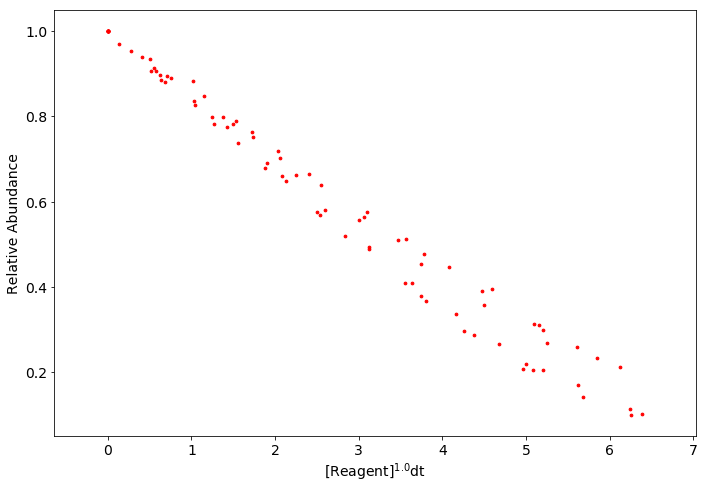

In [143]:
#generate a final plot
plt.figure(figsize=(10,7))
R_final = []
t_vtna = []
for h in range(len(xl.sheet_names)):
    for i,col in enumerate(Rzeroed[h].columns):
        if i > 0:
            R_final.append(Rzeroed[h][col].rolling(1).mean())
            t_vtna.append(Rzeroed[h].iloc[:,0]*float(conc[h])**order)
            plt.scatter(t_vtna[h], R_final[h], marker='.', s = 30, color = 'r')
val = []
for i in range(len(xl.sheet_names)):
    val.append((Rzeroed[i].iloc[:,0]*float(conc[i])**order).max())
    endtime = max(val)
plt.xlim(-endtime/10, endtime+endtime/10)
plt.ylabel('Relative Abundance')
plt.xlabel('[Reagent]$^{{{}}}$dt'.format(str(order)))
#plt.legend([plot1,plot2],[str(conc1)+' mM', str(conc2)+ ' mM'],loc = 'best')
plt.tight_layout(True)
plt.rc('font', size=20)
#plt.savefig('VTNA_rawplot.png', dpi=600, filetype = 'png')
plt.show()


In [144]:
#save the new data
data_out = []
for i in range(len(xl.sheet_names)):
    data_out.append(pd.concat([t_vtna[h],Rzeroed[h]], axis=1))
with open("data_out.txt", 'w') as output:
    for row in data_out:
        output.write(str(row) + '\n')

In [187]:
#catalyst poisoning
#marked by suppressed activity at low concentrations
#treat by lowering the effective concentration
#function which creates interactive plot
#must know order of reaction
def interact_poisoning(Rzeroed, conc, rxn_order, window1=10):
    conc_min = min(conc)
    def poisoned_plot(poison):
        plt.figure(figsize=(10,7))
        R_final = []
        t_vtna = []
        for h in range(len(xl.sheet_names)):
            for i,col in enumerate(Rzeroed[h].columns):
                if i > 0:
                    R_final.append(Rzeroed[h][col].rolling(1).mean())
                    t_vtna.append(Rzeroed[h].iloc[:,0]*float(conc[h]-poison)**order)
                    plt.scatter(t_vtna[h], R_final[h], marker='.', s = 60)
        val = []
        for i in range(len(xl.sheet_names)):
            val.append((Rzeroed[i].iloc[:,0]*float(conc[i])**order).max())
            endtime = max(val)
        plt.xlim(-endtime/10, endtime+endtime/10)
        #plt.title('concentration units poisoning')
        plt.ylabel('Relative Abundance')
        #three curly brackets for formatting decimale numbers as superscript
        plt.xlabel('[Catalyst-{}]$^{{{}}}$dt'.format(str(poison),str(rxn_order)))
        #plt.legend([plot1,plot2],[str(conc1)+' mM', str(conc2)+ ' mM'],loc = 'best')
        plt.rc('font', size=14)
        plt.tight_layout(True)
        plt.show()
    return interactive(poisoned_plot, 
                        poison = ipywidgets.FloatSlider(min=0., max=conc_min, step=conc_min/500., value=0.000, 
                                                           description='{} - Posion'.format(conc_min), continuous_update=False))


In [188]:
poisonedor = interact_poisoning(Rzeroed, conc, order)
display(poisonedor)

A Jupyter Widget

In [197]:
poison = poisonedor.children[0].value
poison

0.01306

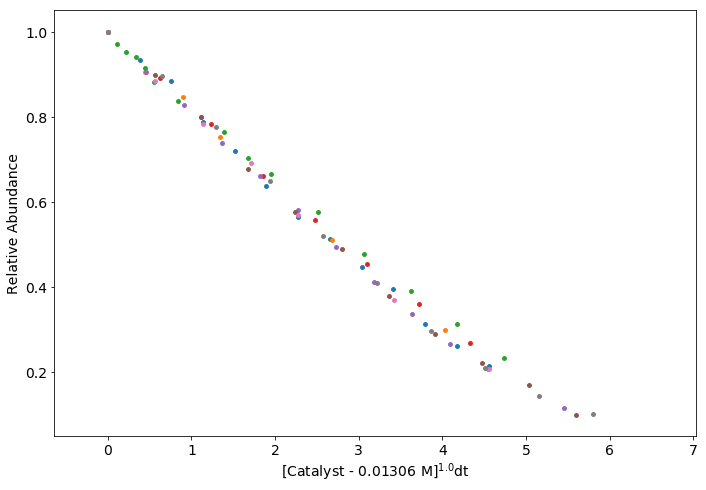

In [198]:
#generate a final plot
plt.figure(figsize=(10,7))
R_final = []
t_vtna = []
for h in range(len(xl.sheet_names)):
    for i,col in enumerate(Rzeroed[h].columns):
        if i > 0:
            R_final.append(Rzeroed[h][col].rolling(1).mean())
            t_vtna.append(Rzeroed[h].iloc[:,0]*float(conc[h]-poison)**order)
            plt.scatter(t_vtna[h], R_final[h], marker='.', s = 60)
val = []
for i in range(len(xl.sheet_names)):
    val.append((Rzeroed[i].iloc[:,0]*float(conc[i])**order).max())
    endtime = max(val)
plt.xlim(-endtime/10, endtime+endtime/10)
plt.ylabel('Relative Abundance')
plt.xlabel('[Catalyst - {} M]$^{{{}}}$dt'.format(poison,str(order)))
#plt.legend([plot1,plot2],[str(conc1)+' mM', str(conc2)+ ' mM'],loc = 'best')
plt.tight_layout(True)
plt.rc('font', size=17)
plt.savefig("1storder_fitpoison.png", dpi = 200)
plt.show()
